### Import

In [1]:
from lib import *

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 16

LABELS = 1.0
BBOX = 1.0

### Load and Inspect DATA

In [3]:
def load_json(json_file):
    print(json_file)
    with open(json_file, "r") as f:
        data = json.load(f)
    return data

dataset = load_json("./data/annotations/instances_val2017.json")
dataset.keys()

./data/annotations/instances_val2017.json


dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

#### Extract Annotation

In [4]:
images = dataset["images"]
annotations = dataset["annotations"]
categories = dataset["categories"]
len(images), len(annotations), len(categories)

(5000, 36781, 80)

In [5]:
images[1000], annotations[1000]

({'license': 1,
  'file_name': '000000010363.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000010363.jpg',
  'height': 361,
  'width': 640,
  'date_captured': '2013-11-15 07:08:52',
  'flickr_url': 'http://farm4.staticflickr.com/3027/2477308902_443e5baf08_z.jpg',
  'id': 10363},
 {'segmentation': [[461.2,
    267.99,
    474.38,
    267.99,
    483.17,
    269.59,
    491.15,
    272.38,
    480.37,
    286.36,
    469.19,
    293.55,
    458.81,
    307.13,
    452.42,
    313.52,
    451.22,
    325.1,
    453.22,
    334.28,
    438.84,
    337.48,
    432.05,
    339.07,
    430.05,
    327.09,
    427.26,
    311.52,
    424.86,
    299.54,
    430.45,
    291.55,
    436.84,
    288.36,
    443.23,
    283.96],
   [414.88,
    301.54,
    406.09,
    311.12,
    408.09,
    321.5,
    406.49,
    331.49,
    408.49,
    337.08,
    412.08,
    341.07,
    417.27,
    335.88]],
  'area': 2443.1682,
  'iscrowd': 0,
  'image_id': 412531,
  'bbox': [406.09, 267.99, 85

##### Extract Classes

In [6]:
DATA_LABELS = ['__background__']
classes = []

for category in categories:
    while int(category['id']) - len(DATA_LABELS) > 0:
        DATA_LABELS.append("None")
    DATA_LABELS.append(category['name'])
    classes.append(category['name'])

print(DATA_LABELS.__len__())
print(classes.__len__())

91
80


In [7]:
image_dir = "./data/val2017"
print("[INFO] loading dataset...")

id_list = []
img_list = []
anno_json = {}
anno_list = []
background_list = []
# Extract image_list
for img in dataset["images"]:
    image_id = img["id"]
    file_name = img["file_name"]
    height = img["height"]
    width = img["width"]
    id_list.append(image_id)
    img_list.append((image_id, file_name, height, width))
    anno_json[image_id] = []

# Extract annotation_list
for anno in dataset["annotations"]:
    image_id = anno["image_id"]
    label = DATA_LABELS[anno["category_id"]] # label_id -> label
    label_id = classes.index(label) # label -> index of label
    x_min, y_min, w, h = anno["bbox"]
    anno_json[image_id].append([x_min, y_min, x_min+w, y_min+h, label_id]) # [x_min, y_min, x_max, y_max, label_id]

for key, value in anno_json.items():
    anno_list.append((key, np.array(value)))
    if value == []:
        background_list.append(key)

id_list = sorted(id_list)
anno_list = sorted(anno_list, key=lambda x: x[0])
img_list = sorted(img_list, key=lambda x: x[0])

img_list = [img for img in img_list if img[0] not in background_list]
anno_list = [anno for anno in anno_list if anno[0] not in background_list]
print("[INFO] loading dataset complete")
print("[INFO] number of images: ", len(img_list))
print("[INFO] number of annotations: ", len(anno_list))
print("[INFO] number of background images: ", len(background_list))

[INFO] loading dataset...
[INFO] loading dataset complete
[INFO] number of images:  4952
[INFO] number of annotations:  4952
[INFO] number of background images:  48


- display sample

In [8]:
def has_four_zeros(arr):
    return np.all(arr[:4] == 0)

for id, ann in enumerate(anno_list):
    if any(has_four_zeros(arr) for arr in ann[1]):
        print(ann)

image_id:  74256
size: 640x480


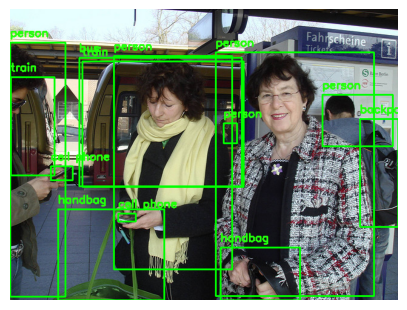

In [9]:
def display_img(img_list, anno_list, i):
    image_id, file_name, height, width = img_list[i]
    print("image_id: ", image_id)
    print("size: {}x{}".format(width, height))
    image = cv2.imread(os.path.join(image_dir, file_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboxes = anno_list[i][1]
    # print(bboxes)
    for bbox in bboxes:
        x_min, y_min, x_max, y_max, label_id = bbox
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        cv2.putText(image, classes[int(label_id)], (int(x_min), int(y_min-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36,255,12), 2)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

display_img(img_list, anno_list, 632)

### Train Test Split

In [10]:
split = train_test_split(img_list, anno_list, test_size=0.2, random_state=42)

(trainImages, testImages) = split[:2]
(trainAnno, testAnno) = split[2:4]
len(trainImages), len(testImages), len(trainAnno), len(testAnno)

(3961, 991, 3961, 991)

In [11]:
trainImages[0], trainAnno[0]

((122745, '000000122745.jpg', 640, 480),
 (122745, array([[216.24, 110.29, 357.01, 252.52,  11.  ]])))

image_id:  376310
size: 640x480


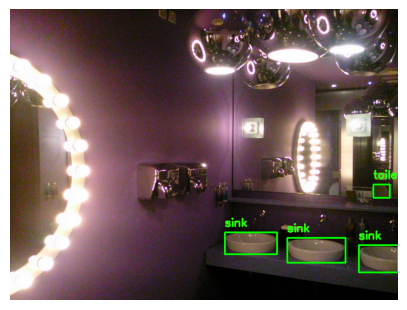

In [12]:
display_img(trainImages, trainAnno, 1)

### MyDataset

In [13]:
from dataset import MyDataset

In [14]:
transform = transforms.Compose([
	transforms.ToPILImage(),
	transforms.Resize((300, 300)),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

In [15]:
root = "./data/val2017"
train_dataset = MyDataset(root, trainImages, trainAnno, transform=transform)
test_dataset = MyDataset(root, testImages, testAnno, transform=transform)
print("[INFO] total training samples: {}...".format(len(train_dataset)))
print("[INFO] total test samples: {}...".format(len(test_dataset)))

[INFO] total training samples: 3961...
[INFO] total test samples: 991...


In [46]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [17]:
def has_four_zeros(arr):
    return np.all(arr[:4] == 0)

for train_data in train_dataset:
    # check [0, 0, 0, 0, 0] in train_data
    if any(has_four_zeros(arr) for arr in train_data[1]):
        print(train_data[1])
        break

### DataLoader

In [18]:
def my_collate_fn(batch):
    _images = []
    _annotations = []

    for sample in batch:
        _images.append(sample[0])
        _annotations.append(torch.FloatTensor(sample[1]))

    _images = torch.stack(_images, dim=0)
    return _images, _annotations

trainLoader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY, collate_fn=my_collate_fn)
testLoader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY, collate_fn=my_collate_fn)

In [19]:
batch = iter(trainLoader)
a, b = next(batch)
print(a.size())
print(len(b))

torch.Size([16, 3, 300, 300])
16


In [20]:
len(trainLoader)

248

In [21]:
# for i, (image, target) in enumerate(trainLoader):
#     print(target)

### Build model

In [22]:
cfg = {
    "num_classes": 81, # + 1 background class
    "input_size": 300, #SSD300
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4], # Tỷ lệ khung hình cho source1->source6`
    "feature_maps": [38, 19, 10, 5, 3, 1],
    "steps": [8, 16, 32, 64, 100, 300], # Size of default box
    "min_size": [30, 60, 111, 162, 213, 264], # Size of default box
    "max_size": [60, 111, 162, 213, 264, 315], # Size of default box
    "aspect_ratios": [[2], [2,3], [2,3], [2,3], [2], [2]]
}

In [23]:
from l2_norm import L2Norm
from defBox import DefBox
from model import SSD
from multibox_loss import MultiBoxLoss

In [24]:
defbox = DefBox(cfg)
dbox_list = defbox.create_defbox()
print(dbox_list.shape)
# print(pd.DataFrame(dbox_list.numpy()))

torch.Size([8732, 4])


In [25]:
ssd = SSD(phase="train", cfg=cfg)
print(ssd)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

### Train

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
torch.backends.cudnn.benchmark = True

color_mean = (104, 117, 123)
input_size = 300

dataloader_dict = {"train": trainLoader, "val": testLoader}

cfg = {
    "num_classes": 81, #VOC data include 20 class + 1 background class
    "input_size": 300, #SSD300
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4], # Tỷ lệ khung hình cho source1->source6`
    "feature_maps": [38, 19, 10, 5, 3, 1],
    "steps": [8, 16, 32, 64, 100, 300], # Size of default box
    "min_size": [30, 60, 111, 162, 213, 264], # Size of default box
    "max_size": [60, 111, 162, 213, 264, 315], # Size of default box
    "aspect_ratios": [[2], [2,3], [2,3], [2,3], [2], [2]]
}

net = SSD(phase="train", cfg=cfg)
# vgg_weights = torch.load("./data/weights/vgg16_reducedfc.pth")
# net.vgg.load_state_dict(vgg_weights)
net_weights = torch.load("./data/weights/ssd300_10.pth", map_location={"cuda:0":"cpu"})
net.load_state_dict(net_weights)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# # He init
# net.extras.apply(weights_init)
# net.loc.apply(weights_init)
# net.conf.apply(weights_init)

device: cuda:0


In [27]:
from lib import *
from utils.box_utils import *

class MultiBoxLoss(nn.Module):
    def __init__(self, jaccard_threshold=0.5, neg_pos=3, device="cpu"):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_threshold = jaccard_threshold
        self.neg_pos = neg_pos
        self.device = device
    
    def forward(self, predictions, targets):
        loc_data, conf_data, dbox_list = predictions

        #(batch_num, num_dbox, num_classes)
        num_batch = loc_data.size(0) 
        num_dbox = loc_data.size(1) #8732
        num_classes = conf_data.size(2)

        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        for idx in range(num_batch):
            truths = targets[idx][:, :-1].to(self.device) #(xmin, ymin, xmax, ymax) BBox
            print("-"*10)
            print(truths)
            print("-"*10)
            if (truths == 0).all(dim=1).any():
                print("⚠️ Found [0, 0, 0, 0] in truths!")
                print(f"Before removing: {truths.shape}")
                print(truths)
                print("-"*10)
                # remove [0, 0, 0, 0] in truths
                truths = truths[~(truths == 0).all(dim=1)]
                print(f"After removing: {truths.shape}")
                print(truths)
                print("-"*10)
                
            labels = targets[idx][:, -1].to(self.device) #label

            dbox = dbox_list.to(self.device)
            variances = [0.1, 0.2]
            match(self.jaccard_threshold, truths, dbox, variances, labels, loc_t, conf_t_label, idx)

        #SmoothL1Loss
        pos_mask = conf_t_label > 0
        # loc_data(num_batch, 8732, 4)
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # positive dbox, loc_data
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        loss_loc = F.smooth_l1_loss(loc_p, loc_t, reduction="sum")

        conf_t_label_ = conf_t_label.view(-1)
        assert conf_t_label_.min() >= 0 and conf_t_label_.max() < num_classes, "⚠️ Label out of range!"

        #loss_conf
        #CrossEntropy
        batch_conf = conf_data.view(-1, num_classes) #(num_batch*num_box, num_classes)
        loss_conf = F.cross_entropy(batch_conf, conf_t_label_, reduction="none")

        # hard negative mining
        num_pos = pos_mask.long().sum(1, keepdim=True)
        loss_conf = loss_conf.view(num_batch, -1) # torch.size([num_batch, 8732])

        _, loss_idx = loss_conf.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)
        # idx_rank chính là thông số để biết được độ lớn loss nằm ở vị trí bao nhiêu

        num_neg = torch.clamp(num_pos*self.neg_pos, max=num_dbox)
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        #(num_batch, 8732) -> (num_batch, 8732, 21)
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)
        conf_t_pre = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)].view(-1, num_classes)
        conf_t_label_ = conf_t_label[(pos_mask+neg_mask).gt(0)]
        loss_conf = F.cross_entropy(conf_t_pre, conf_t_label_, reduction="sum")

        # total loss = loss_loc + loss_conf
        N = num_pos.sum()
        loss_loc = loss_loc/N
        loss_conf = loss_conf/N

        return loss_loc, loss_conf

In [28]:
# MultiBoxLoss
criterion = MultiBoxLoss(jaccard_threshold=0.5, neg_pos=3, device=device)
# optimizer
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [29]:
# training, validation
def train_model(net, dataloader_dict, criterion, optimizer, num_epochs):
    # move network to GPU
    net.to(device)

    iteration = 1
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    logs = []
    for epoch in range(num_epochs+1):
        t_epoch_start = time.time()
        t_iter_start = time.time()
        print("---"*20)
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("---"*20)
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
                print("(Training)")
            else:
                if (epoch+1) % 10 == 0:
                    net.eval() 
                    print("---"*10)
                    print("(Validation)")
                else:
                    continue
            for images, targets in dataloader_dict[phase]:
                # move to GPU
                images = images.to(device)
                targets = [ann.to(device) for ann in targets]
                # init optimizer
                optimizer.zero_grad()
                # forward
                with torch.set_grad_enabled(phase=="train"):
                    outputs = net(images)
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    if phase == "train":
                        loss.backward() # calculate gradient
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                        optimizer.step() # update parameters

                        if (iteration % 10) == 0:
                            t_iter_end = time.time()
                            duration = t_iter_end - t_iter_start
                            print("Iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec".format(iteration, loss.item(), duration))
                            t_iter_start = time.time()
                        epoch_train_loss += loss.item()
                        iteration += 1
                    else:
                        epoch_val_loss += loss.item()
        t_epoch_end = time.time()
        print("---"*20)
        print("Epoch {} || epoch_train_loss: {:.4f} || Epoch_val_loss: {:.4f}".format(epoch+1, epoch_train_loss, epoch_val_loss))           
        print("Duration: {:.4f} sec".format(t_epoch_end - t_epoch_start))
        t_epoch_start = time.time()

        log_epoch = {"epoch": epoch+1, "train_loss": epoch_train_loss, "val_loss": epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("./data/ssd_logs.csv")
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), "./data/weights/ssd300_" + str(epoch+1) + ".pth")

In [ ]:
for i in range(10):
    for images, targets in trainLoader:
        try:
            for idx in range(len(targets)):
                truths = targets[idx][:, :-1].to(DEVICE) #(xmin, ymin, xmax, ymax) BBox
                if (truths == 0).all(dim=1).any():
                    print("⚠️ Found [0, 0, 0, 0] in truths!")
                    print(f"Before removing: {truths.shape}")
                    print(truths)
                    print("-"*10)
                    # remove [0, 0, 0, 0] in truths
                    truths = truths[~(truths == 0).all(dim=1)]
                    print(f"After removing: {truths.shape}")
                    print(truths)
                    print("-"*10)
        except Exception as e:
            print(e)
            print(targets)
            for idx in range(BATCH_SIZE):
                truths = targets[idx][:, :-1].to(DEVICE)
            print("----------continue----------")

In [ ]:
num_epochs = 100
train_model(net, dataloader_dict, criterion, optimizer, num_epochs=num_epochs)